# BERTweet fine-tuned classifier for sarcasm detection

Based on the notebook: https://chriskhanhtran.github.io/_posts/2019-12-25-bert-for-sentiment-analysis/

# Installs/imports

In [1]:
!pip install transformers

In [2]:
!pip install emoji

In [3]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

# from transformers import BertTokenizer, BertModel
# from transformers import RobertaTokenizer, RobertaModel
from transformers import AutoModel, AutoTokenizer

from transformers import AdamW, get_linear_schedule_with_warmup
%matplotlib inline

In [4]:
# setup GPU
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


# Load dataset

In [5]:
training_data = pd.read_csv('/content/balanced_train_En.csv')
training_data

,Unnamed: 0,Unnamed: 0.1,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,341,341,@Dancruz07 Sureeeeeee you do,1,"I could've replied ""You do not despise me, you...",1.0,0.0,0.0,0.0,0.0,0.0
1,138,138,"@BoardroomBoy Few links for you. To summarise,...",1,"I would omit the ""who'da thunk"" part.",1.0,0.0,0.0,0.0,0.0,1.0
2,241,241,#bbcqt It sure would be nice if Ms May decided...,1,Theresa May just needs to answer the question.,1.0,0.0,0.0,0.0,0.0,0.0
3,1359,1359,Someone in Walmart asked my mom if I was a boy...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,588,588,Being a mom with an autoimmune disease means I...,1,I wouldn't because sarcasm is the only weapon ...,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1557,1635,1635,i was so bored today that i let my computer re...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1558,2306,2306,It is midnight. On a Thursday. My roommates de...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1559,3149,3149,"when i was taken off anesthesia today, i told ...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1560,1153,1153,@savingfilm @_celia_bedelia_ I have zero tampo...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
validation_data = pd.read_csv('/content/balanced_validation_En.csv')
validation_data

,Unnamed: 0,Unnamed: 0.1,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,2708,2708,The meaning behind Little Talks - @monstersand...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3416,3416,Kyle is out of town so i made a baked ziti and...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3254,3254,Applying for jobs is so weird and feels fake,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,293,293,@lora__ SHOCKED. How am I supposed to tell the...,1,These people were aware of the risks when they...,1.0,0.0,0.0,0.0,0.0,0.0
4,1,1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
167,656,656,Is spunk a slur?,1,I am worried that I may have used a slur by sa...,0.0,1.0,0.0,0.0,0.0,1.0
168,1653,1653,OH MY GOD I AM IN LOVE WITH MY FIANCÉ. https:/...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169,3074,3074,Just get yer jab and shut yer moof,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170,43,43,"I suppose though, we did sign one for the futu...",1,I wish we could have signed a player for the f...,1.0,0.0,0.0,1.0,0.0,0.0


In [7]:
# Set label to use in binary classifcation
LABEL_TO_CLASSIFY = 'sarcastic'

In [8]:
# Get training and validation input(X) and label(y) sets
X_train = training_data['tweet']
X_val = validation_data['tweet']
y_train = training_data[LABEL_TO_CLASSIFY]
y_val = validation_data[LABEL_TO_CLASSIFY]

# Tokenize the data

In [9]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", normalization=True)
# tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
# tokenizer = RobertaTokenizer.from_pretrained("roberta-base", do_lower_case=False)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.



Length of encoded posts:


count    1734.000000
mean       24.192618
std        12.974467
min         3.000000
25%        15.000000
50%        21.000000
75%        31.000000
max        80.000000
dtype: float64

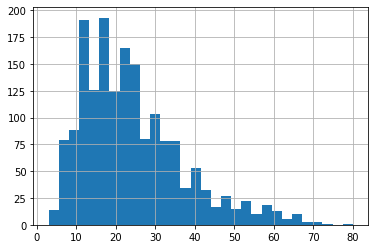

In [10]:
# Analyze post lengths after processing. This block is not required.

all_posts = pd.concat([training_data, validation_data])['tweet']

# Encode our concatenated data
encoded_posts = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_posts]

# get length of all the messages in the train set
seq_len = [len(i) for i in encoded_posts]

print("\nLength of encoded posts:")
pd.Series(seq_len).hist(bins = 30)

pd.Series(seq_len).describe()

In [11]:
# Specify `MAX_LEN`
MAX_LEN = 100

# Print sentence 1 and its encoded token ids
token_ids = list(preprocessing_for_bert([X_train[0]])[0].squeeze().numpy())
print('Original: ', X_train[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  @Dancruz07 Sureeeeeee you do
Token IDs:  [0, 5, 41817, 14205, 14, 32, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Tokenizing data...


# Create dataloaders

In [12]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Define model class

In [13]:
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        # self.bert = RobertaModel.from_pretrained('roberta-base')
        # self.bert = BertModel.from_pretrained('bert-base-cased')
        self.bert = AutoModel.from_pretrained("vinai/bertweet-base")

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.33),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [14]:
def initialize_model(current_train_dataloader, epochs=5):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate is 1e-3
                      eps=1e-8,    # Default epsilon value is 1e-6
                      weight_decay=.01
                      )
   
    # Total number of training steps
    total_steps = len(current_train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

# Define training and evaluation loops

In [15]:
# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):

        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        
        # Evaulation 
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [16]:
# AUC/Accuracy evaluation function

from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Train model

In [17]:
set_seed(42)    # Set seed for reproducibility
EPOCHS = 5

bert_classifier, optimizer, scheduler = initialize_model(train_dataloader, epochs=EPOCHS)
train(bert_classifier, train_dataloader, val_dataloader, epochs=EPOCHS, evaluation=True)

Downloading:   0%|          | 0.00/517M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True`

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.690568   |     -      |     -     |   6.81   
   1    |   40    |   0.695161   |     -      |     -     |   6.40   
   1    |   48    |   0.685463   |     -      |     -     |   2.53   
----------------------------------------------------------------------
   1    |    -    |   0.691609   |  0.675624  |   58.33   |   16.28  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.647531   |     -      |     -     |   6.72   
   2    |   40    |   0.630520   |     -      |     -     |   6.39   
   2    |   48    |   0.605473   |     -      |     -     |   2.53   
-----------------------------------------------------------------

# Define predictor function

In [18]:
def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

# Evaluation

AUC: 0.7664
Accuracy: 73.26%


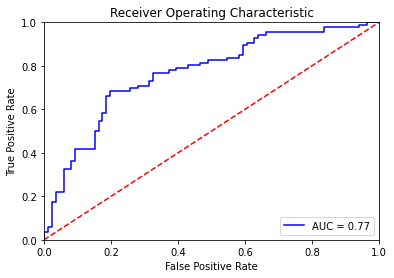

In [19]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [20]:
# Compute predicted probabilities on the validation set
probs = bert_predict(bert_classifier, val_dataloader)

# Get predictions from the probabilities
preds = np.argmax(probs, axis = 1)

# Number of tweets predicted non-negative
print("Number of posts predicted non-negative: ", preds.sum())

Number of posts predicted non-negative:  78


In [21]:
from sklearn.metrics import classification_report
# preds = np.argmax(preds, axis = 1)
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.71      0.78      0.74        86
           1       0.76      0.69      0.72        86

    accuracy                           0.73       172
   macro avg       0.73      0.73      0.73       172
weighted avg       0.73      0.73      0.73       172



In [22]:
print('Incorrect negative predictions:\n--------------------')
for sent in X_val[(preds==0) & (y_val.values==1)]:
  print(sent)
print()
print('Incorrect positive predictions:\n--------------------')
for sent in X_val[(preds==1) & (y_val.values==0)]:
  print(sent)

Incorrect negative predictions:
--------------------
If you don't like Lemonade you're an extremist 🍋
My eldest is having a wild Friday night out. She's going to bingo. 😂
Men will literally fake an injury on the football field instead of going to therapy
It would be a real shame if people shared this around and filled it with fake info. People should definitely not do that 😉
https://t.co/Px7dYqjh3I
Joey the genius! I wish i was as brainy as him #towie
Great night last night! Muggins here is the commis chef crouched down in the corner. Seriously an honour to help raise money for @acf_uk and work alongside these stellar chefs. Thanks for having us @nickg67 @frontlinechef! https://t.co/mkiTEpMzaz https://t.co/SVgdFYHyi4
Lucky for 2nd placed Brentford that there's no stand out team like Leeds this year, or they might have no chance of winning the league. #ncfc
It was the jerseys
Every time I see an establishment with paper straws I turn a little bit Republican
finished the queen's gambit, 

# Save model to file

In [23]:
# torch.save(bert_classifier, 'test_model.pth')

In [24]:
# !tar -czvf "test_model.tar.gz" "test_model.pth"